### 根据质量求解密度

$$l_i = x_{i+1/2} - x_{i-1/2}$$
$$\rho = m/l$$
$$e = \frac{p}{(\gamma -1)\rho}$$

### 添加人工粘性

$$p = p + q$$
$$q_i = \left\{ \begin{aligned}
1.5\rho_il_ic_i|\frac{\partial u}{\partial x}|
            +0.06\rho_il_i^2\left(\frac{\partial u}{\partial x}\right)^2  \quad \text{if} \quad \frac{\partial u}{\partial x} <0\\
            0 \text{else}
            \end{aligned} \right.
            $$

### 右端项

$$\text{rhsu}_{i+1/2} = -\frac{(p_{i+1}- p_i)}{m_{p,i+1/2}}$$
$$\text{rhse}_i = -\frac{p_i(u_{i+1/2}-u_{i-1/2})}{m_i}$$

$$m_{p,i+1/2} \approx \frac{m_{i}+m_{i+1}}{2}$$

### 推进

$$ x  = x +dt* u$$
$$ u = u + dt* \text{rhsu}$$
$$ e = e + dt* \text{rhse}$$

### 求解新的密度和压力

$$l_i = x_{i+1/2} - x_{i-1/2}$$
$$\rho = m/l$$
$$ p = (\gamma -1)\rho e$$


In [314]:
function init()
    I = 1000
    u = zeros(Float64,I+1)
    x = zeros(Float64,I+1)
    l = zeros(Float64,I)
    p = zeros(Float64,I)
    ρ = zeros(Float64,I)
    m = zeros(Float64,I)
    e = zeros(Float64,I)
    γ = 1.4
    
    Δx = 1.0/I
    l .= Δx
    
    tt = 0.14
    sf =0.1
    # init
    
    for i in 1:I 
        u[i] = 0
        
        
        if i >I/2
            p[i] = 0.1
            ρ[i] = 0.125
            m[i] =ρ[i]*Δx
        else
            p[i] = 1.0
            ρ[i] = 1.0
            m[i] = ρ[i]*Δx
        end
    end
    
    for i in 1:I+1
        x[i] = i*Δx
    end
    
    
    e = pToe(p,ρ,γ)
return sf,tt,γ,u,x,m,p
end

            
            

init (generic function with 1 method)

In [15]:
function pToe(p,ρ,γ)
    return p ./ ρ/(γ-1)
end
function eTop(e,ρ,γ)
    return (γ-1)*ρ .* e
end

eTop (generic function with 1 method)

In [192]:
function timeSolve(sf, tt,γ,u,x,m,p)
    t= 0.0

    I, = size(m)
    ρ = zeros(Float64,I)
       while t<tt
#for i in 1:1
        dt=CFL(sf,γ,x,u,p,m)
        if t+dt>tt
           dt = tt-t
        end
        u,x,p,ρ = Euler1st(γ,dt,u,x,p,m)
        t += dt
        
        println(t)
    end
#
    return u,x,p,ρ
end

timeSolve (generic function with 1 method)

In [196]:
function Euler1st(γ,dt,u,x,p,m)
    I, = size(p)
    
    l = zeros(Float64,I)
    x₀ = zeros(Float64,I+1)
    u₀ = zeros(Float64,I+1)
    e₀ = zeros(Float64,I)
    
     for i in 1:I
        l[i] = x[i+1]-x[i]
    end
    
    ρ = m ./ l     
    e = pToe(p, ρ,γ)    
    
    p = artificial_viscosity!(γ,l,p,ρ,x,u) 
      
    rhsu, rhse = Rhs(x,l,u,p,m)
  
    x₀  = x+ dt .* u
    u₀  = u+ dt .* rhsu
    e₀  = e+ dt .* rhse
    

    
    for i in 1:I
        l[i] = x₀[i+1]-x₀[i]
    end
    
    ρ = m ./ l
    p = eTop(e, ρ,γ)
#    p = artificial_viscosity!(γ,l,p,ρ,x₀,u₀)
    
    rhsu₀, rhse₀ = Rhs(x₀,l,u₀,p,m)
    
    x  += 1/2 *dt*(u +u₀)
    u  += 1/2 *dt*(rhsu + rhsu₀)
    e  += 1/2 *dt*(rhse + rhse₀)
    
    for i in 1:I
        l[i] = x[i+1]-x[i]
    end
    
    ρ = m ./ l
    p = eTop(e, ρ,γ)
    
    
    return u,x,p,ρ
end

Euler1st (generic function with 1 method)

## 预估校正方法 （二阶）

$$\frac{dy}{dx} = f(x,y)$$

$$y_0 = y_n + dx f(x_n,y_n)$$

$$y_{n+1} = y_n + \frac{1}{2} dx [f(x_n, y_n) + f(x_{n+1},y_0)] $$

In [206]:
function Rhs(x,l,u,p,m)
    I, = size(m)
    rhsu = zeros(Float64,I+1)
    rhse = zeros(Float64,I)
    for i in 1:I-1
        rhsu[i+1] = - 2(p[i+1] - p[i])/(m[i] +m[i+1])
    end
    for i in 1:I
        rhse[i] = - p[i]*(u[i+1]-u[i])/m[i]
    end

    return rhsu,rhse
    
    end
    

Rhs (generic function with 1 method)

In [303]:
function artificial_viscosity!(γ, l,p,ρ,x,u)
    I, = size(p)
    for i in 1:I
        c = √(γ*p[i]/ρ[i])
        ∂u_∂x = (u[i+1]- u[i])/(x[i+1]-x[i])
        q = 0
        if ∂u_∂x < 0 
        q = 1.5ρ[i]*l[i]*c*abs(∂u_∂x)
            +2.5ρ[i]*l[i]^2*(∂u_∂x)^2 
        end
        p[i] = p[i] +q
    
    end
    return p
end

artificial_viscosity! (generic function with 1 method)

In [20]:
  function CFL(sf,γ,x,u,p,m)
    dlmin = 1e8
    umax = 0.0
    I, = size(p)
    l = zeros(Float64,I)
    ρ = zeros(Float64,I)
    
     for i in 1:I
        l[i] = x[i+1]-x[i]
    end
    
    ρ = m ./ l
    for i in 1:I
        c  = √(γ*p[i]/ρ[i])
        u2 = u[i] + c 
        if abs(u2) > umax
            umax = abs(u2)
        end
        if l[i] < dlmin
            dlmin = l[i]
        end
    end
    cfl = dlmin/umax*sf
    return cfl
end

CFL (generic function with 1 method)

In [315]:
sf,tt,γ,u,x,m,p = init()
u,x,p,ρ = timeSolve(sf, tt, γ, u, x, m,p)

8.451542547284233e-5
0.0001687591942209621
0.0002502823293181321
0.0003260687639619267
0.00039684058773155063
0.0004632046681951578
0.0005256726168634646
0.0005846781592410419
0.0006405914775276014
0.0006937307627411528
0.0007443714221866432
0.0007927534013711713
0.0008390870213747296
0.0008835576579388874
0.00092632951861441
0.000967548715929155
0.001007345788325852
0.0010458377850228208
0.0010831300039045475
0.0011193174511191907
0.0011544860756438596
0.001188713820420284
0.0012220715228094885
0.0012546236903518211
0.001286429172619332
0.0013175417459209678
0.0013480106244788163
0.0013778809092221428
0.0014071939833866958
0.0014359878625411424
0.0014642975054017801
0.0014921550907737295
0.0015195902651205793
0.0015466303645761772
0.0015733006146416908
0.0015996243103352744
0.001625622979162463
0.0016513165289386434
0.001676723382209449
0.0017018605987720564
0.0017267439875927912
0.0017513882092388656
0.0017758068697896763
0.0018000126070624204
0.0018240171698746454
0.0018478314909704

0.011069519605580455
0.011091055361662258
0.011112590932915934
0.011134126540858406
0.011155662403946302
0.011177198735647648
0.011198735742509432
0.01122027361626035
0.01124181252571733
0.011263352616562595
0.011284894011347668
0.011306436809680593
0.011327981088587786
0.0113495269030406
0.011371074286635445
0.011392623252415194
0.011414173793818734
0.011435725885744702
0.011457279485714905
0.011478834535122577
0.01150039096055031
0.011521948675142632
0.011543507580018238
0.011565067565707353
0.011586627525554833
0.011608185210589641
0.011629740855540803
0.01165129467987264
0.011672846888180433
0.011694397670552694
0.011715947202911811
0.011737495647343683
0.011759043151877693
0.011780589845168705
0.011802135838106373
0.011823681225366384
0.011845226086874373
0.01186677048918591
0.011888314486785918
0.011909858123310517
0.011931401432694074
0.011952944440244008
0.011974487163645605
0.011996029613898946
0.012017571796189844
0.012039113710696584
0.012060655353334206
0.012082196716438044

0.029570740810997444
0.029592140255560208
0.029613539683108515
0.029634939093740317
0.029656338487553464
0.029677737864645694
0.02969913722511464
0.029720536569057793
0.02974193589657253
0.029763335207756078
0.029784734502705527
0.0298061337815178
0.029827533043212503
0.02984893228721131
0.02987033151361239
0.02989173072251385
0.029913129914013712
0.029934529088209906
0.02995592824520028
0.029977327385082575
0.029998726507954425
0.030020125613913356
0.03004152470305677
0.030062923775481944
0.03008432283128603
0.030105721870566034
0.030127120893418815
0.030148519899941082
0.030169918890229384
0.030191317864380104
0.03021271682248946
0.03023411576465348
0.030255514690968002
0.03027691360152868
0.03029831249643096
0.030319711375770084
0.030341110239641075
0.030362509088138732
0.030383907921357627
0.030405306739392096
0.030426705542336226
0.03044810433028386
0.03046950310332858
0.0304909018615637
0.03051230060508226
0.030533699333977024
0.030555098048340463
0.030576496748264757
0.030597895

0.040376204524339425
0.04039759985581523
0.04041899518203262
0.0404403905029972
0.0404617858187146
0.040483181129190464
0.04050457643443042
0.040525971734440135
0.04054736702922526
0.04056876231879148
0.04059015760314447
0.04061155288228992
0.04063294815623352
0.04065434342498099
0.040675738688538035
0.04069713394691037
0.040718529200103735
0.040739924448123854
0.04076131969097647
0.04078271492866733
0.04080411016120218
0.04082550538858679
0.04084690061082692
0.040868295827928336
0.04088969103989682
0.04091108624673814
0.04093248144845809
0.04095387664506245
0.04097527183655701
0.040996667022947575
0.04101806220423994
0.0410394573804399
0.04106085255155327
0.041082247717585854
0.041103642878543456
0.041125038034431884
0.04114643318525696
0.0411678283310245
0.041189223471740324
0.041210618607410245
0.04123201373804009
0.04125340886363569
0.04127480398420285
0.041296199099747403
0.04131759421027517
0.04133898931579198
0.04136038441630365
0.041381779511816014
0.04140317460233489
0.0414245

0.059523481766035426
0.05954487411374564
0.059566266459440645
0.05958765880312239
0.05960905114479282
0.059630443484453885
0.05965183582210752
0.05967322815775567
0.05969462049140028
0.05971601282304328
0.0597374051526866
0.05975879748033218
0.05978018980598194
0.05980158212963781
0.05982297445130171
0.05984436677097557
0.0598657590886613
0.059887151404360815
0.05990854371807603
0.05992993602980886
0.05995132833956121
0.059972720647334984
0.05999411295313209
0.06001550525695443
0.06003689755880389
0.06005828985868238
0.0600796821565918
0.06010107445253402
0.06012246674651094
0.06014385903852445
0.060165251328576426
0.060186643616668756
0.06020803590280332
0.06022942818698199
0.060250820469206635
0.060272212749479144
0.06029360502780137
0.06031499730417519
0.060336389578602455
0.06035778185108504
0.06037917412162481
0.060400566390223606
0.060421958656883296
0.06044335092160573
0.06046474318439275
0.06048613544524622
0.06050752770416798
0.06052891996115987
0.06055031221622373
0.060571704

0.07049752889272072
0.07051892041561336
0.07054031193723014
0.07056170345757207
0.0705830949766402
0.07060448649443558
0.07062587801094816
0.07064726952617506
0.07066866104011733
0.07069005255277604
0.07071144406415221
0.07073283557424692
0.07075422708306121
0.07077561859059614
0.07079701009685276
0.0708184016018321
0.07083979310553523
0.07086118460796319
0.07088257610911701
0.07090396760899774
0.07092535910760643
0.07094675060494413
0.07096814210101185
0.07098953359581064
0.07101092508934155
0.07103231658160561
0.07105370807260385
0.07107509956233729
0.07109649105080698
0.07111788253801396
0.07113927402395925
0.07116066550864389
0.07118205699206888
0.07120344847423528
0.07122483995514409
0.07124623143479634
0.07126762291319307
0.07128901439033529
0.07131040586622402
0.07133179734086027
0.07135318881424509
0.07137458028637945
0.07139597175726442
0.07141736322690098
0.07143875469529015
0.07146014616243296
0.0714815376283304
0.07150292909298349
0.07152432055639324
0.07154571201856065
0.0

0.09013451186763721
0.09015590253551413
0.09017729320272433
0.09019868386926824
0.0902200745351463
0.09024146520035892
0.09026285586490651
0.09028424652878951
0.09030563719200833
0.09032702785456341
0.09034841851645514
0.09036980917768396
0.0903911998382503
0.09041259049815455
0.09043398115739715
0.09045537181597851
0.09047676247389908
0.09049815313115923
0.09051954378775941
0.09054093444370001
0.09056232509898147
0.0905837157536042
0.09060510640756861
0.09062649706087512
0.09064788771352415
0.09066927836551611
0.09069066901685141
0.09071205966753049
0.09073345031755374
0.09075484096692157
0.09077623161563442
0.09079762226369267
0.09081901291109676
0.09084040355784707
0.09086179420394405
0.0908831848493881
0.0909045754941796
0.09092596613831899
0.09094735678180668
0.09096874742464307
0.09099013806682858
0.09101152870836361
0.09103291934924858
0.09105430998948388
0.09107570062906993
0.09109709126800714
0.0911184819062959
0.09113987254393664
0.09116126318092976
0.09118265381727567
0.0912

0.1011934069091166
0.10121479728109585
0.10123618765258473
0.10125757802358351
0.10127896839409248
0.1013003587641119
0.10132174913364207
0.10134313950268324
0.1013645298712357
0.10138592023929972
0.10140731060687556
0.10142870097396352
0.10145009134056385
0.10147148170667683
0.10149287207230274
0.10151426243744185
0.10153565280209444
0.10155704316626077
0.10157843352994111
0.10159982389313575
0.10162121425584494
0.10164260461806897
0.1016639949798081
0.10168538534106261
0.10170677570183277
0.10172816606211885
0.10174955642192111
0.10177094678123984
0.1017923371400753
0.10181372749842775
0.10183511785629748
0.10185650821368475
0.10187789857058983
0.101899288927013
0.10192067928295452
0.10194206963841466
0.10196345999339369
0.10198485034789188
0.1020062407019095
0.10202763105544682
0.1020490214085041
0.10207041176108161
0.10209180211317963
0.10211319246479841
0.10213458281593822
0.10215597316659934
0.10217736351678203
0.10219875386648655
0.10222014421571318
0.1022415345644622
0.10226292

0.11017732313353962
0.11019871332156311
0.11022010350919621
0.11024149369643912
0.11026288388329206
0.1102842740697552
0.11030566425582877
0.11032705444151296
0.11034844462680797
0.110369834811714
0.11039122499623126
0.11041261518035995
0.11043400536410028
0.11045539554745244
0.11047678573041665
0.1104981759129931
0.110519566095182
0.11054095627698354
0.11056234645839792
0.11058373663942535
0.11060512682006603
0.11062651700032015
0.11064790718018794
0.11066929735966957
0.11069068753876525
0.11071207771747518
0.11073346789579956
0.1107548580737386
0.1107762482512925
0.11079763842846144
0.11081902860524563
0.11084041878164529
0.11086180895766058
0.11088319913329173
0.11090458930853893
0.11092597948340238
0.11094736965788228
0.11096875983197883
0.11099015000569222
0.11101154017902265
0.11103293035197033
0.11105432052453545
0.11107571069671822
0.11109710086851882
0.11111849103993744
0.1111398812109743
0.1111612713816296
0.11118266155190351
0.11120405172179625
0.11122544189130801
0.11124683

0.12121461252063395
0.12123600253123361
0.12125739254153078
0.12127878255152563
0.12130017256121829
0.12132156257060889
0.12134295257969757
0.1213643425884845
0.12138573259696979
0.12140712260515359
0.12142851261303604
0.12144990262061728
0.12147129262789745
0.1214926826348767
0.12151407264155516
0.12153546264793297
0.12155685265401028
0.12157824265978723
0.12159963266526394
0.12162102267044057
0.12164241267531725
0.12166380267989413
0.12168519268417134
0.12170658268814903
0.12172797269182732
0.12174936269520636
0.1217707526982863
0.12179214270106727
0.1218135327035494
0.12183492270573285
0.12185631270761774
0.12187770270920421
0.12189909271049242
0.12192048271148248
0.12194187271217455
0.12196326271256876
0.12198465271266525
0.12200604271246414
0.12202743271196559
0.12204882271116974
0.1220702127100767
0.12209160270868664
0.12211299270699968
0.12213438270501596
0.12215577270273563
0.12217716270015881
0.12219855269728565
0.12221994269411628
0.12224133269065084
0.12226272268688947
0.122

0.13233738024653607
0.13235877011692962
0.13238015998708305
0.1324015498569965
0.13242293972667005
0.1324443295961038
0.13246571946529787
0.13248710933425234
0.13250849920296734
0.13252988907144295
0.13255127893967927
0.1325726688076764
0.13259405867543445
0.1326154485429535
0.13263683841023372
0.13265822827727514
0.13267961814407786
0.13270100801064202
0.1327223978769677
0.132743787743055
0.13276517760890402
0.13278656747451487
0.13280795733988765
0.13282934720502246
0.13285073706991937
0.1328721269345785
0.13289351679899997
0.13291490666318387
0.1329362965271303
0.13295768639083935
0.13297907625431113
0.13300046611754573
0.13302185598054325
0.13304324584330382
0.1330646357058275
0.1330860255681144
0.13310741543016463
0.1331288052919783
0.13315019515355547
0.13317158501489626
0.1331929748760008
0.13321436473686912
0.1332357545975014
0.13325714445789769
0.13327853431805808
0.1332999241779827
0.13332131403767164
0.133342703897125
0.13336409375634287
0.13338548361532535
0.133406873474072

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.25927e-16, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01  …  0.992, 0.993, 0.994, 0.995, 0.996, 0.997, 0.998, 0.999, 1.0, 1.001], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125])

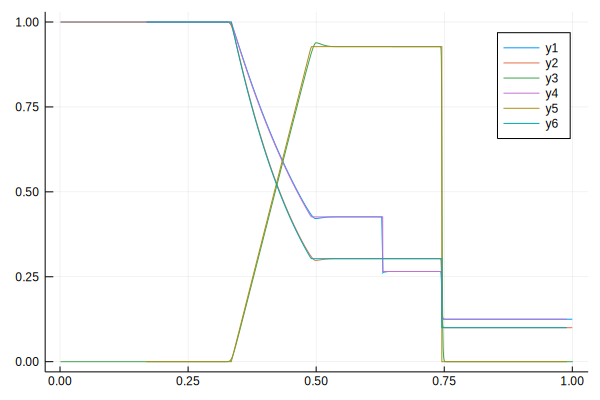

In [318]:
#using Plots
plot(x[1:end-1],ρ)
plot!(x[1:end-1],p)
plot!(x[1:end],u)
plot!(x1 .+ 0.5,U[:,1:3])

In [100]:
push!(LOAD_PATH, "/home/bfly/workspace/computeforcfd/Lag2D/")

6-element Array{String,1}:
 "@"                                        
 "@v#.#"                                    
 "@stdlib"                                  
 "/home/bfly/workspace/computeforcfd/Lag2D/"
 "/home/bfly/workspace/computeforcfd/Lag2D/"
 "/home/bfly/workspace/computeforcfd/Lag2D/"

In [10]:
using Riemann

In [312]:
Wₗ = W(1.0,0.0,1.0)
Wᵣ = W(0.125,0.0,0.1)
γ = 1.4
x1,U = SolveDistr(0.14,Wₗ,Wᵣ,γ)

([-0.3313, -0.330472, -0.329644, -0.328816, -0.327987, -0.327159, -0.326331, -0.325503, -0.324674, -0.323846  …  0.478339, 0.479565, 0.480792, 0.482018, 0.483245, 0.484471, 0.485698, 0.486924, 0.488151, 0.489377], [1.0 0.0 1.0; 1.0 0.0 1.0; … ; 0.125 0.0 0.1; 0.125 0.0 0.1])

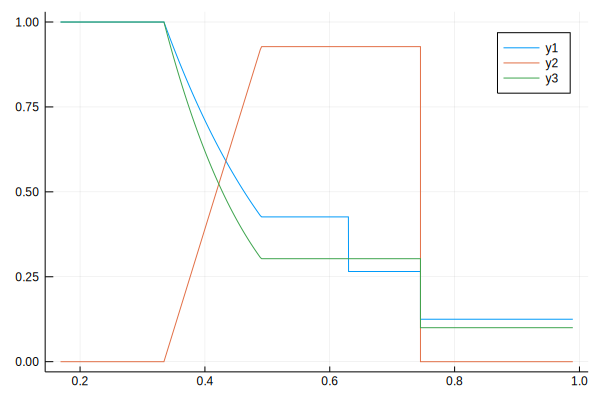

In [313]:
plot(x1 .+ 0.5,U)